In [238]:
%load_ext autoreload
%autoreload 2

import torch
import time
import math
import cv2

import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from torch.utils.data import DataLoader
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.train.helper import get_test_transform
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config
from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast.models import utils
from diveslowlearnfast.utils import tensor_denorm, numpy_to_video

from torch.optim import Adam


cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 4
cfg.DATA.NUM_FRAMES = 16
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model, device)
model, *_ = load_checkpoint(model, optimiser, '../misc/run22_best.pth', device)
model.eval()
train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg),  # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# DiveSlow Layer Visualisation

In [10]:
x, y, _, _, video_id, *_ = train_dataset.__getitem__(400)

x.shape, train_dataset.get_label(y), video_id

(torch.Size([3, 16, 256, 256]),
 ['Back', '15som', 'NoTwis', 'PIKE'],
 '-mmq0PT-u8k_00083')

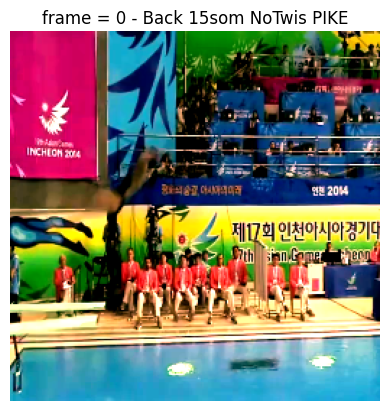

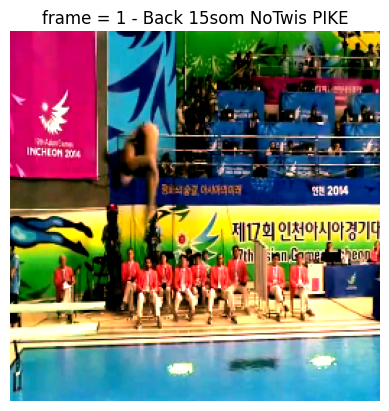

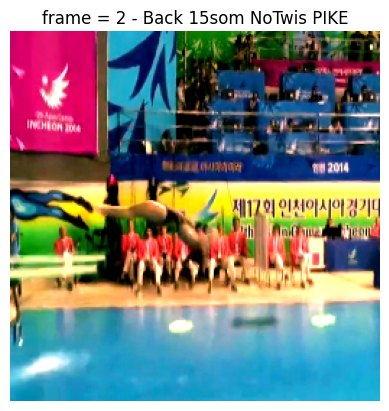

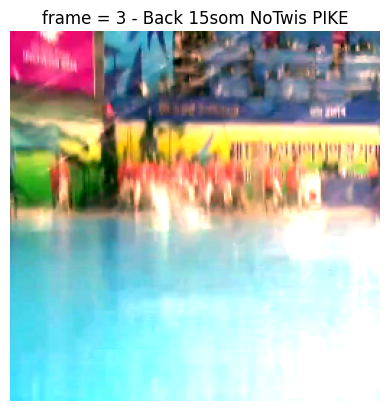

In [244]:
# take frames 0-7
for idx, frame in enumerate(x.permute(1, 2, 3, 0)[::4]):
    plt.title(f"frame = {idx} - {' '.join(train_dataset.get_label(y))}")
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [ ]:
# get the 15som sub sequence
_15som = x[:, 0:7].unsqueeze(0)
padded_15som = torch.zeros(1, 3, 16, 256, 256)
padded_15som[:, :, 0:7] = _15som
inputs = utils.to_slowfast_inputs(padded_15som, alpha=cfg.SLOWFAST.ALPHA)

inputs[0].shape, inputs[1].shape

In [241]:
def _repeat_video_tensor(tensor, T):
    B, C, t, H, W = tensor.shape
    repeated_tensor = torch.zeros(B, C, T, H, W)
    for i in range(math.ceil(T / t)):
        start  = i * t
        end = min((i + 1) * t, T)
        repeated_tensor[:, :, start:end] = tensor[:, :, 0:end-start]

    return repeated_tensor

In [242]:
x_repeated = _repeat_video_tensor(x[:, 0:7].unsqueeze(0), 16)

In [289]:
utils.get_layer(model, 's5/pathway0_output')

KeyError: 'pathway0_output'

In [12]:
model.eval()

SlowFast(
  (s1): VideoModelStem(
    (pathway0_stem): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (pathway1_stem): ResNetBasicStem(
      (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
  )
  (s1_fuse): FuseFastToSlow(
    (conv_f2s): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(8, 1, 1), padding=(3, 0, 0), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [90]:
_preprocess_video = get_test_transform(cfg)

def _postprocess_video(video):
    return tensor_denorm(video,
                         torch.tensor(cfg.DATA.MEAN),
                         torch.tensor(cfg.DATA.STD)).detach().numpy()


def _resize_video(video, size):
    return np.stack([cv2.resize(frame, (size, size), interpolation=cv2.INTER_CUBIC) for frame in video])

def _blur_video(video, blur):
    return np.stack([cv2.blur(frame, (blur, blur)) for frame in video])

class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()


class FilterVisualizer():
    def __init__(self, model, size=56, t=16, upscaling_steps=12, upscaling_factor=1.2):
        self.size = size
        self.t = t
        self.upscaling_steps = upscaling_steps
        self.upscaling_factor = upscaling_factor

        self.model = model

        # Set model to non-trainable (equivalent to set_trainable(self.model, False))
        for param in self.model.parameters():
            param.requires_grad = False

    def visualize(self, layer_name, filter_idx, lr=0.1, opt_steps=20, blur=None, alpha=1):
        sz = self.size

        # Generate random image (equivalent to the original code's random image)
        video = np.uint8(np.random.uniform(150, 180, (self.t, sz, sz, 3))) / 255.0

        # Get the target layer
        target_layer = utils.get_layer(self.model, layer_name)

        # Register hook
        activations = SaveFeatures(target_layer)


        for _ in range(self.upscaling_steps):
            # Convert image to tensor with proper normalization
            video_var = _preprocess_video(video).unsqueeze(0)
            video_var.requires_grad = True

            # Setup optimizer
            optimizer = Adam([video_var], lr=lr, weight_decay=1e-6)

            # Optimization loop
            for n in range(opt_steps):
                optimizer.zero_grad()
                self.model(utils.to_slowfast_inputs(video_var, alpha=alpha))

                # Target activation: maximize the mean activation of the specified filter
                loss = -activations.features[0, filter_idx].mean()

                loss.backward()
                optimizer.step()

            # Convert the optimized tensor back to numpy image
            video = _postprocess_video(video_var).squeeze()

            # Calculate new image size and scale up
            sz = int(self.upscaling_factor * sz)
            video = _resize_video(video, sz)
            #
            # Apply blur if specified
            if blur is not None:
                video = _blur_video(video, blur)

            self.output = video.copy()


        activations.close()

In [273]:
layer_name = 'head/projection'
layer = utils.get_layer(model, layer_name)
activations = SaveFeatures(layer)

In [274]:
inputs = utils.to_slowfast_inputs(x_repeated, alpha=cfg.SLOWFAST.ALPHA)

In [275]:
model.zero_grad()
o = model(inputs)
y == torch.argmax(o)

tensor(True)

In [278]:
mean_act = [activations.features[0,i].mean().item() for i in range(192)]
mean_act

IndexError: index 1 is out of bounds for dimension 1 with size 1

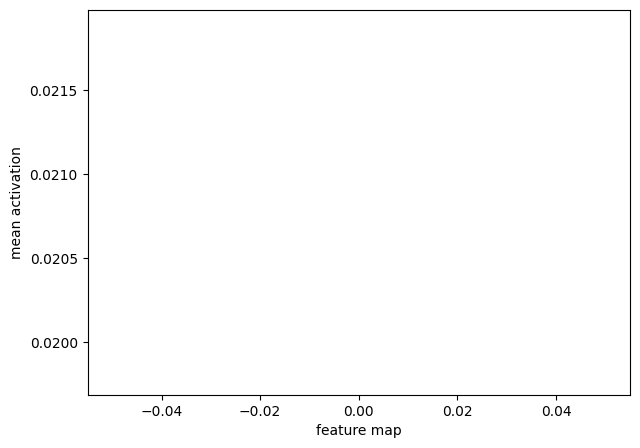

(None, array([0]))

In [272]:
def plot_mean_act(mean_act):
    plt.figure(figsize=(7,5))
    act = plt.plot(mean_act,linewidth=2.)
    ax = act[0].axes
    ax.set_xlabel("feature map")
    ax.set_ylabel("mean activation")
    plt.show()

plot_mean_act(mean_act), np.argsort(mean_act)[:5]

In [264]:
filter_idx = 22

model.zero_grad()
visualizer = FilterVisualizer(model, size=56, t=16, upscaling_steps=12, upscaling_factor=1.2)
visualizer.visualize(layer_name, filter_idx=filter_idx, alpha=cfg.SLOWFAST.ALPHA, blur=2)

In [254]:
visualizer.output.shape

(16, 489, 489, 3)

In [265]:
def plot_visualiser_output(video, layer_name, filter_idx, label, video_id, save=False):
    fig, axes = plt.subplots(2, 8)
    fig.set_size_inches(14, 5)
    fig.subplots_adjust(hspace=-0.4)
    fig.suptitle(f'Filter Visualization: \n Layer = {layer_name}, Filter = {filter_idx}, \n Label = {label}, Video ID = {video_id}')
    for row_idx, row in enumerate(axes):
        for col_idx, col in enumerate(row):
            idx = row_idx * 8 + col_idx
            col.imshow(video[idx])
            col.axis('off')


    if save:
        plt.savefig(f'./data/deepdream/{layer_name.replace('/', '.')}_{filter_idx}_{video_id}.png')

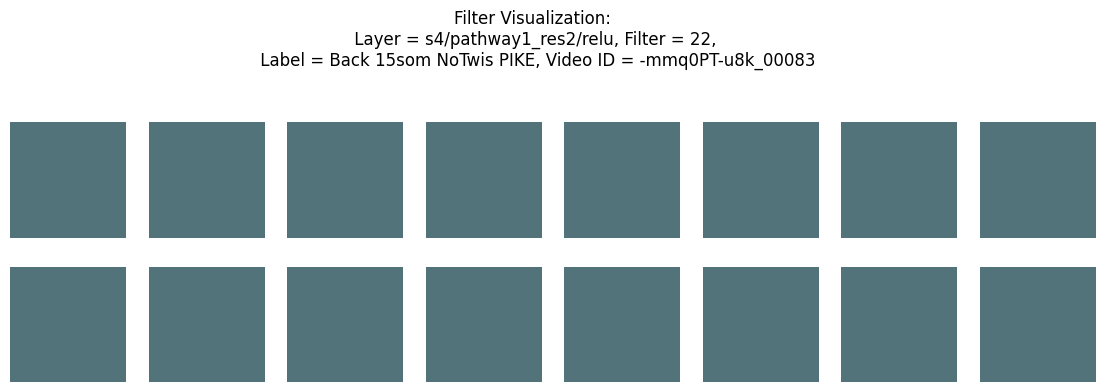

In [266]:
label = ' '.join(train_dataset.get_label(y))
plot_visualiser_output(
    visualizer.output,
    layer_name,
    filter_idx,
    label,
    video_id,
    save=True
)

In [221]:
def _min_max_normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

video = visualizer.output
video = np.uint8(_min_max_normalize(video) * 255)
numpy_to_video(video, f'data/deepdream/{layer_name.replace('/', '.')}_{filter_idx}_{video_id}.mp4')